# 実習6
### CBOWをkerasで実装

### 参照
(https://github.com/nzw0301/keras-examples/blob/master/CBoW.ipynb)


In [0]:
import numpy as np
np.random.seed(13)

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

/Users/Niioka/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [0]:
# 学習データの準備1

#get_fileでalice.txtをダウンロード (get_fileについては-->https://keras.io/ja/utils/)
path = get_file('alice.txt', origin='http://www.gutenberg.org/files/11/11-0.txt')

#readlines() – ファイルを全て読み込み、1行毎に処理を行う。1000行まで読み込む。
corpus = open(path).readlines()[:1000]

corpus

In [0]:
# 学習データの準備2

#spaceが2個以上の要素を返す。つまり、単語が3つ以上の文章。
corpus = [sentence for sentence in corpus if sentence.count(' ') >= 2]

corpus

In [0]:
# 学習データの準備3

#単語列を単語ID列に変換
#Tokenizerを作成
tokenizer = Tokenizer() # 例えば引数として num_words = 100とすると単語IDを100までしか設定しない。引数がないときは最大値をとってくれる。
#単語のインデックスを構築
tokenizer.fit_on_texts(corpus)
#文字列を整数のインデックスのリストに変換
corpus = tokenizer.texts_to_sequences(corpus)

#corpusが単語IDのリストになってることを確認
corpus

In [0]:
#単語IDの数(単語数)をカウント
nb_samples = sum(len(s) for s in corpus)

# 次元数 = 語彙数 (単語IDの種類)
# (後続処理で、空文字分の0が増えるため+1する)
vocab_size = len(tokenizer.word_index) + 1

#windowサイズの設定
window_size = 1

In [0]:
# 学習データを作成
#def generate_data(corpus, window_size, vocab_size):
contexts = []
targets   = []   
for words in corpus:
    L = len(words)
    for index, word in enumerate(words): 
        s = index - window_size
        e = index + window_size + 1
            
        #コンテキストとtargetの作成
        contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
        targets.append(word)

        x_train = sequence.pad_sequences(contexts, maxlen=window_size*2) #sequenceが全て同じ長さになるよう0で埋める(パディング)
        y_train = np_utils.to_categorical(targets, vocab_size) #one-hotデータに変換

In [0]:
#x_train(context)とy_train(target)を見てみる
print(x_train.shape, y_train.shape)
print(x_train[0:7])
print(y_train[0:7])
print(y_train[0][781])
print(y_train[1][782])
print(y_train[2][186])

#単語IDの最大値が1597とわかる(語彙数は1596)

(9259, 2) (9259, 1597)
[[  0 782]
 [781 186]
 [782 321]
 [186  11]
 [321 322]
 [ 11  68]
 [322 510]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1.0
1.0


In [0]:
# ハイパーパラメータ
hidden_size = 100
batch_size = 32
max_epoch = 50

In [0]:
#　学習を行う

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=hidden_size, input_length=window_size*2))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(hidden_size,))) #k.meanは要素の平均を計算
model.add(Dense(vocab_size, activation='softmax'))
model.summary()
#(Embedding)のparameter数がちゃんと1597(語彙数)x 100(中間層のノード数)になっている

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2, 100)            159700    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1597)              161297    
Total params: 320,997
Trainable params: 320,997
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [0]:
# 学習
hist = model.fit(x_train, y_train, 
                 batch_size=batch_size, 
                 epochs=max_epoch,
                 verbose=1,
                 validation_split=0.1)

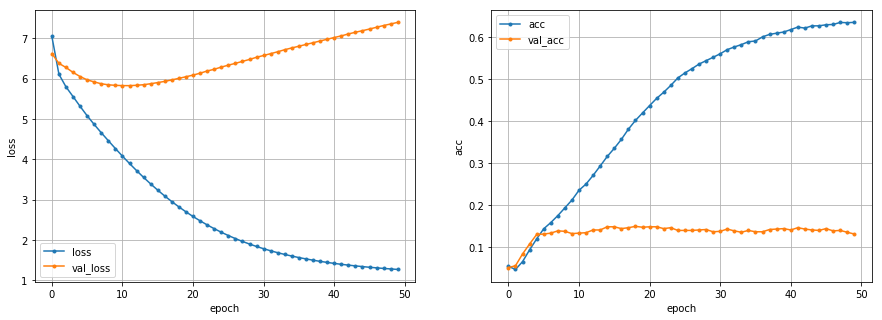

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(max_epoch), loss, marker='.', label='loss')
plt.plot(range(max_epoch), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(max_epoch), acc, marker='.', label='acc')
plt.plot(range(max_epoch), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

In [0]:
#重みを保存するファイルを作る
f = open('CBOW_vectors.txt' ,mode='w') 
f.write('{} {}\n'.format(vocab_size-1, hidden_size)) #{}にそれぞれvocab_size-1とhidden_sizeが書き込まれる。
#open()の引数modeを'w'とすると書き込み用としてファイルが開かれる。
#ファイルが存在しなければ新規作成、存在していれば上書き（既存の内容は削除）で保存される。

9

In [0]:
vectors = model.get_weights()[0] #入力層と中間層の間の重みの取得
for word, i in tokenizer.word_index.items(): 
    str_vec = ' '.join(map(str, list(vectors[i, :])))
    f.write('{} {}\n'.format(word, str_vec))
f.close()

#tokenizer.word_index.items()は単語と単語IDのdictionary
#str_vecは各word毎の重みベクトル<--これと単語をセットにして.txtファイルとして保存

In [0]:
#tokenizer.word_index.items()の中身を見る
tokenizer.word_index.items()

dict_items([('the', 1), ('and', 2), ('to', 3), ('she', 4), ('a', 5), ('’', 6), ('it', 7), ('of', 8), ('was', 9), ('i', 10), ('in', 11), ('alice', 12), ('her', 13), ('that', 14), ('you', 15), ('as', 16), ('said', 17), ('for', 18), ('had', 19), ('at', 20), ('little', 21), ('be', 22), ('this', 23), ('but', 24), ('all', 25), ('with', 26), ('on', 27), ('down', 28), ('very', 29), ('out', 30), ('so', 31), ('not', 32), ('is', 33), ('herself', 34), ('up', 35), ('mouse', 36), ('me', 37), ('about', 38), ('one', 39), ('no', 40), ('if', 41), ('do', 42), ('‘i', 43), ('what', 44), ('they', 45), ('then', 46), ('thought', 47), ('way', 48), ('again', 49), ('like', 50), ('when', 51), ('or', 52), ('there', 53), ('see', 54), ('know', 55), ('went', 56), ('how', 57), ('here', 58), ('could', 59), ('think', 60), ('rabbit', 61), ('time', 62), ('get', 63), ('into', 64), ('quite', 65), ('were', 66), ('them', 67), ('by', 68), ('would', 69), ('oh', 70), ('must', 71), ('my', 72), ('i’m', 73), ('now', 74), ('thing', 

In [0]:
# gensimを使って学習したCBOWの重み(単語の分散表現)を取り出す
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./CBOW_vectors.txt', binary=False)

In [0]:
# 入力した単語と近いベクトルを列挙する
word2vec.most_similar(positive=['not'])

/Users/Niioka/anaconda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nor', 0.5902115702629089),
 ('stigand', 0.5540261268615723),
 ('feeling', 0.5229634642601013),
 ('tale', 0.4807059168815613),
 ('can’t', 0.47442078590393066),
 ('chain', 0.45854058861732483),
 ('they’ll', 0.4231773018836975),
 ('hoped', 0.4148193597793579),
 ('i’d', 0.41418004035949707),
 ('pope', 0.41221606731414795)]

#### おまけ

gensimを使うとwikipediaを学習済みの公開モデルを使うことができる

(参考)　http://kento1109.hatenablog.com/entry/2017/11/15/230004

In [0]:
import urllib.request 

url = "https://www.dropbox.com/s/exdl3wc83n2mfia/entity_vector.zip?dl=0" # 保存したいファイルのURLを指定 (dropboxのURLを指定する際は、最後のdl=0をdl=1に設定する)
save_name = "entity_vector.zip" # byori_dataset.zipという名前で保存される。
 
# ダウンロードを実行
urllib.request.urlretrieve(url, save_name)

In [0]:
#uploadしたzipファイルを解凍する
import zipfile
with zipfile.ZipFile("entity_vector.zip","r") as zip_ref:
    zip_ref.extractall("") #""の中にはディレクトリのpathが入る

In [0]:
from gensim.models import KeyedVectors
model_dir = 'entity_vector/entity_vector.model.bin'
model = KeyedVectors.load_word2vec_format(model_dir, binary=True)
similar_rugby_list = model.most_similar(u'[ラグビー]')
for similar_set in similar_rugby_list:
    print (similar_set[0])
    print (similar_set[1])

ラグビー
0.7684316039085388
[サッカー]
0.7571812868118286
[アイスホッケー]
0.719829797744751
[ハンドボール]
0.7171785235404968
[バレーボール]
0.7139065265655518
[バスケットボール]
0.7011639475822449
[女子野球]
0.6983809471130371
[ソフトボール]
0.6887843608856201
サッカー
0.6880793571472168
[水球]
0.6868013143539429


/Users/Niioka/anaconda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
from gensim.models import KeyedVectors
model_dir = 'entity_vector/entity_vector.model.bin'
model = KeyedVectors.load_word2vec_format(model_dir, binary=True)
similar_rugby_list = model.most_similar(positive=[u'[新宿]',u'[大阪府]'],negative=[u'[東京都]'])
for similar_set in similar_rugby_list:
    print (similar_set[0])
    print (similar_set[1])

[梅田]
0.6829696297645569
[ミナミ]
0.6623619794845581
[日本橋_(大阪市)]
0.6565461158752441
[心斎橋]
0.655109167098999
[千日前]
0.645991861820221
[難波]
0.6324416995048523
阿倍野
0.6287933588027954
[新世界_(大阪)]
0.6217558979988098
[北新地]
0.6190609335899353
[キタ]
0.6080436706542969


/Users/Niioka/anaconda/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


#### おまけ2
UMAPという圧縮手法を使って重みを2次元まで圧縮し、単語の分散表現を取得して表示

pip install umap-learnでインストールする必要がある

In [0]:
# 分散表現の取得
w2v = model.get_weights()[0]

# クラスタリング
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=529).fit(w2v)

# 次元圧縮
from umap import UMAP
w2v_umap = UMAP().fit_transform(w2v)

# クラスタ内で頻度上位の語を取得
from itertools import compress
for c in set(kmeans.labels_):
    print('cluster %s' % c)
    for w, i in list(compress(sorted(tokenizer.word_index.items(), key=lambda x: x[1]), kmeans.labels_[1:] == c))[:10]:
        print(w, end=' ')
    print()

# クラスタごとに色分けプロット
from matplotlib import cm
for c in set(kmeans.labels_):
  # クラスタ内で頻度上位の語を注釈
    for w, i in list(compress(sorted(tokenizer.word_index.items(), key=lambda x: x[1]), kmeans.labels_[1:] == c))[:5]:
        plt.annotate(w, (w2v_umap[i, 0], w2v_umap[i, 1]))

    v = w2v_umap[kmeans.labels_ == c]
    plt.scatter(v[:, 0], v[:, 1], label=c, cmap=cm.hsv, alpha=0.8)

plt.legend()
plt.show()

"""
UMAPについて
https://qiita.com/cheerfularge/items/27a55ebde4a671880666
"""